## Prerequisites

In [14]:
! pip install numpy
! pip install torch

1775.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/home/yonathan95/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/yonathan95/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


1784.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/home/yonathan95/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/yonathan95/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/yonathan95/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/yonathan95/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 890.2 MB 6.8 kB/s  eta 0:00:01    |█                               | 26.1 MB 20.5 MB/s eta 0:00:43     |███▉

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Assignment1

### Oscillator

In [30]:
def calc_grad(x1, x2, delta_t=0.01):
    return (x2 - x1)/ delta_t

def conv_to_2d(seqs, seq_length=20):
    data = []
    for s in seqs:
        seq = [None] * seq_length
        seq[0] = [s[0], 0]
        for i in range(1, len(seq)):
            seq[i] = [s[i], calc_grad(s[i-1], s[i])]
        data.append(np.array(seq))
    return data
    

def generate_harmonic_oscillator_sequence(delta_t = 0.01, seq_length=20):
    x_0 = random.random()
    xs = [None] * seq_length
    xs[0] = x_0
    xs[1] = x_0 - 0.5 * x_0 * (delta_t**2)
    
    for i in range(1, seq_length - 1):
        xs[i+1] = 2.0 * xs[i] - xs[i-1] - xs[i] * (delta_t**2)
    return xs
    

### Generate data

In [4]:
train_data = []
for i in range(400):
    train_data.append(generate_harmonic_oscillator_sequence())

test_data = []
for i in range(100):
    test_data.append(generate_harmonic_oscillator_sequence())


### Plot

In [85]:
def prepare_data(sequence):
    x_pos = [x[0] for x in sequence]
    v_pos = [x[1] for x in sequence]
    x_direct = v_pos
    v_direct = [None] * len(v_pos)
    v_direct[0] = 0
    for i in range(1, len(v_direct)):
        v_direct[i] = calc_grad(v_pos[i-1], v_pos[i])
    
    return x_pos, v_pos, x_direct, v_direct

def plot_phase_diagram(data, title):
    x_pos = []
    v_pos = []
    x_direct = []
    v_direct = []
    for s in data:
        sx_pos, sv_pos, sx_direct, sv_direct = prepare_data(s)
        x_pos += sx_pos
        v_pos += sv_pos
        x_direct += sx_direct
        v_direct += sv_direct

    # Creating plot
    fig, ax = plt.subplots(figsize = (12, 7))
    ax.quiver(x_pos, v_pos, x_direct, v_direct)
    
    ax.axis([-1.5, 1.5, -1.5, 1.5])
    
    # show plot
    plt.grid()
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('V',rotation=0)
    plt.show()

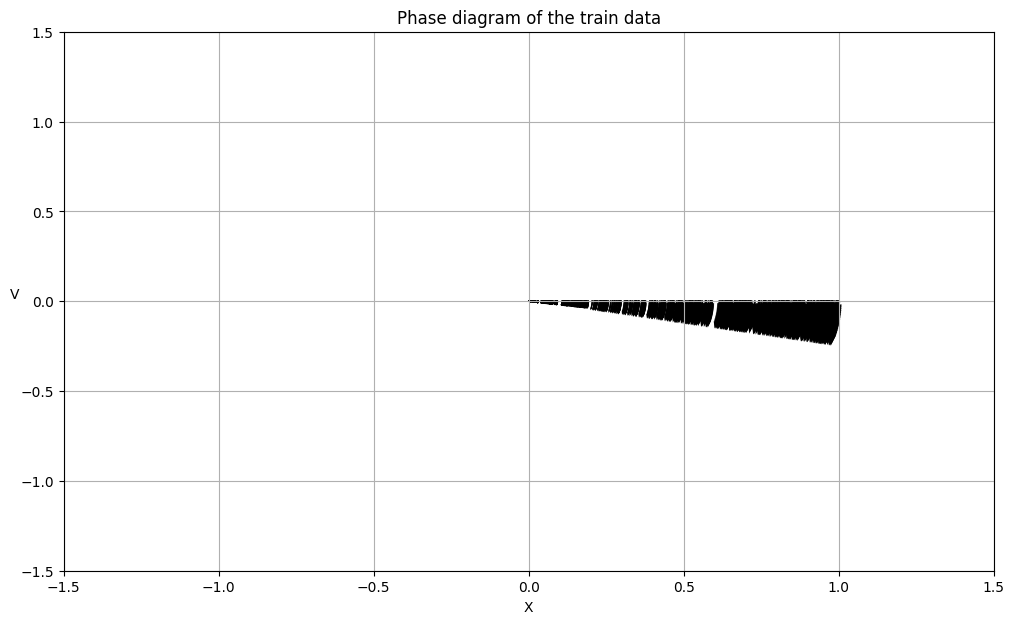

In [86]:
plot_phase_diagram(conv_to_2d(train_data), 'Phase diagram of the train data')

### Model

In [14]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

# number of points
sequence_length = 20
hidden_size = 10
input_size = 1
output_size = 1
lr = 0.01


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] => [seq, h]  (batch=1)
        out = out.reshape(-1, hidden_size)  # stack batch and seq

        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev


In [ ]:
### Train

In [ ]:
model = RNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
epochs = 100
hidden_prev = torch.zeros(1, 1, hidden_size)  # [b, layer, mem_size]

train_err = []
test_err = []

for e in range(epochs):
    # Train
    t_loss = 0
    random.shuffle(train_data)
    for data in train_data:
        x = torch.tensor(data[:-1]).float().reshape(1, sequence_length - 1, 1)  # [b, seq_len, fea_len]
        y = torch.tensor(data[1:]).float().reshape(1, sequence_length - 1, 1)  # [b, seq_len, fea_len]

        output, hidden_prev = model(x, hidden_prev)
        hidden_prev = hidden_prev.detach()

        loss = criterion(output, y)
        model.zero_grad()

        loss.backward()
        optimizer.step()
        t_loss += loss.detach()
        
    train_err.append(t_loss/ 400)

    # Test
    hidden_prev = torch.zeros(1, 1, hidden_size)  # [b, layer, mem_size]
    t_loss = 0
    with torch.no_grad():
        for data in test_data:
            x = torch.tensor(data[:-1]).float().reshape(1, sequence_length - 1, 1)
            y = torch.tensor(data[1:]).float().reshape(1, sequence_length - 1, 1)

            output, hidden_prev = model(x, hidden_prev)
            hidden_prev = hidden_prev.detach()

            t_loss += criterion(output, y).detach()
        test_err.append(t_loss / 100)
            

In [69]:
model2 = RNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr)
epochs = 100

train_err = []
test_err = []

for e in range(epochs):
    # Train
    t_loss = 0
    random.shuffle(train_data)
    for i in range(1, 41):
        hidden_train_prev = torch.zeros(1, 10, hidden_size)
        train = train_data[(i-1)*10 : i*10]
        train_x = [d[:-1] for d in train]
        train_y = [d[1:] for d in train]
        x = torch.tensor(train_x).float().reshape(10, sequence_length - 1, 1)  
        y = torch.tensor(train_y).float().reshape(10, sequence_length - 1, 1) 

        output, hidden_train_prev = model2(x, hidden_train_prev)
        hidden_train_prev = hidden_train_prev.detach()

        loss = criterion(output.reshape(10, sequence_length - 1, 1), y)
        model2.zero_grad()

        loss.backward()
        optimizer.step()
        t_loss += loss.detach()
        
    train_err.append(t_loss/ 400)

    # Test
    
    t_loss = 0
    with torch.no_grad():
        for data in test_data:
            hidden_test_prev = torch.zeros(1, 1, hidden_size)
            x = torch.tensor(data[:-1]).float().reshape(1, sequence_length - 1, 1)
            y = torch.tensor(data[1:]).float().reshape(1, sequence_length - 1, 1)

            output, hidden_test_prev = model2(x, hidden_test_prev)
            hidden_test_prev = hidden_test_prev.detach()

            t_loss += criterion(output, y).detach()
        test_err.append(t_loss / 100)
            

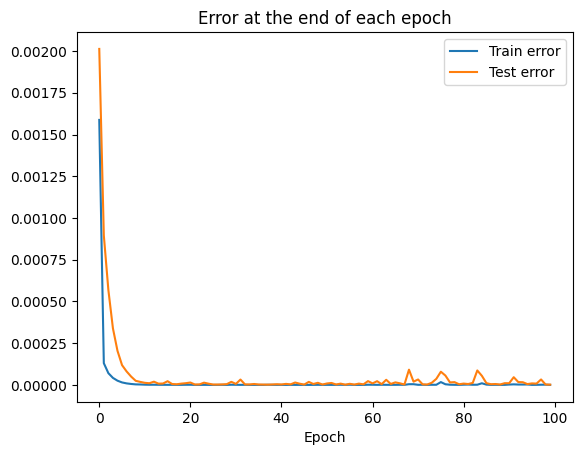

In [70]:
plt.plot(train_err, label='Train error')
plt.plot(test_err, label='Test error')
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title('Error at the end of each epoch')
plt.legend()

## 3.

In [87]:
def predict_traj(s):
    with torch.no_grad():
        traj = [s]
        hidden_prev = torch.zeros(1, 1, hidden_size)
        last = torch.tensor(s).float().reshape(1, 1, 1)
        for _ in range(19):
            last, hidden_prev = model2(last, hidden_prev)
            traj.append(float(last.squeeze().detach().numpy()))
        
        return traj

ts = []
for _ in range(10000):
    s = random.random()
    ts.append(predict_traj(s))
plot_phase_diagram(conv_to_2d(ts), 'Phase diagram of the 10000 predicted values')